In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
df_sentences = pd.read_csv('data/tika_transcript_sentences.csv', index_col=0)
df_speech = pd.read_csv('data/tika_transcript_clean.csv', index_col=0)
df_sentences.head()

,text,clean_text
0,"PRESIDENT RODRIGO ROA DUTERTE: Good day, my co...",good day my countrymen
1,We are here gathered to render a report weekly...,we are here gathered to render a report weekly...
2,Kaya kami nandito at marami namang haka-haka p...,kaya kami nandito at marami namang hakahaka pa...
3,"Gawain mo na, masama ka pa rin.",gawain mo na masama ka pa rin
4,"Kung hindi mo gawin, mas lalo kang masama.",kung hindi mo gawin mas lalo kang masama


In [4]:
df_sentences = df_sentences.dropna()
df_sentences.head()

,text,clean_text
0,"PRESIDENT RODRIGO ROA DUTERTE: Good day, my co...",good day my countrymen
1,We are here gathered to render a report weekly...,we are here gathered to render a report weekly...
2,Kaya kami nandito at marami namang haka-haka p...,kaya kami nandito at marami namang hakahaka pa...
3,"Gawain mo na, masama ka pa rin.",gawain mo na masama ka pa rin
4,"Kung hindi mo gawin, mas lalo kang masama.",kung hindi mo gawin mas lalo kang masama


In [33]:
MAX_NUM = 3000
df_sentences = df_sentences.loc[:MAX_NUM]
df_sentences.shape

(2996, 3)

## Tokenize Sentences

In [34]:
from keras.preprocessing.text import Tokenizer

def tokenize(sentences):
  # integer encode sequences of words
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(sentences)
  sequences = tokenizer.texts_to_sequences(sentences)

  return tokenizer, sequences

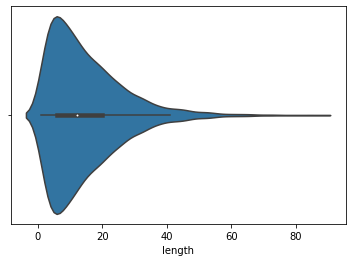

In [35]:
df_sentences['length'] = df_sentences['clean_text'].apply(lambda x: len(x.split()))
sns.violinplot(x=df_sentences['length'])

In [36]:
def get_max(df_sentences):
  sentences_list = df_sentences['clean_text'].astype(str).values.tolist()
  tokenizer, sequences = tokenize(sentences_list)
  max_index = np.argmax([len(x) for x in sequences])
  # Remove the row with 1k+ words
  return max_index, tokenizer, sequences

In [37]:
# Keep running this until the longest sentence makes sense
max_index, tokenizer, sequences = get_max(df_sentences)
long_text = df_sentences.loc[max_index]['text']
df_sentences = df_sentences.drop(max_index)
long_text

'Maghintay lang kayo, nandiyan na.'

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = int(df_sentences['length'].mean()-5)
sequences = pad_sequences(sequences,padding='post',truncating='post', maxlen=max_length)
sequences[:10]

array([[ 126,  233,   86, 2796,    0,    0,    0,    0,    0],
       [  17,   26,  177, 1364,    4, 1829,   12,  139, 1102],
       [  87,  117,  584,   16,  205,  234, 1833, 1834,  285],
       [ 657,   36,    2,  766,   54,   62,   95,    0,    0],
       [  28,   23,   36,  656,  161,  246,  542,  766,    0],
       [ 658,  338,   64,   31,   12,  309,    6, 1835,    1],
       [  56, 1372, 1104,   97,  197, 2802, 1105, 2803,    0],
       [  51,   37,  234,  586,  310,   16,   37,  234, 2804],
       [   7,   35, 2805,  660,   56,   27,  143, 2806,   24],
       [   8,  587,    3,  157,   15,   18,  423,   57,   15]],
      dtype=int32)

In [39]:
vocab_size = len(tokenizer.word_index) + 1

In [42]:
from keras.utils import to_categorical
import itertools

# separate into input and output
NUM_SENTENCES = 2
X = list()
y = list()
for i in range(NUM_SENTENCES, len(sequences)):
  curr_sequence = sequences[i]
  for j in range(max_length):
    prev_words = curr_sequence[:j]
    input = np.concatenate(sequences[i-NUM_SENTENCES:i])
    input = np.append(input, prev_words)
    X.append(input)
    y.append(curr_sequence[j])

X = np.array(pad_sequences(X,padding='pre',truncating='post', maxlen=max_length*(NUM_SENTENCES+1)-1))
y = to_categorical(y, num_classes=vocab_size)
# y = (np.arange(y.max()) == y[...,None]-1).astype(int)
seq_length = X.shape[1]
X.shape

(26946, 26)

In [43]:
y.shape

(26946, 6010)

## Save Sequence

In [44]:
np.save('data/X_sequences.npy', X)

In [48]:
np.save('data/y_sequences.npy', y)

In [47]:
import pickle

with open('tokenizer.pickle', 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)